In [1]:
import pandas as pd

def csv_to_pandas(filepath):
    try:
        df = pd.read_csv(filepath)
        return df
    except FileNotFoundError:
        print(f"Error: File '{filepath}' not found.")
    except pd.errors.EmptyDataError:
        print(f"Error: File '{filepath}' is empty.")
    except pd.errors.ParserError:
        print(f"Error: File '{filepath}' could not be parsed.")


In [2]:
# load and convert to pandas
charging_sessions = csv_to_pandas("./Data Share/charging_sessions.csv")
weather_burbank_airport = csv_to_pandas("./Data Share/weather_burbank_airport.csv")

In [3]:
# add missing values by interpolation
numeric_cols = ['temperature', 'felt_temperature', 'windspeed', 'pressure']
weather_burbank_airport[numeric_cols] = weather_burbank_airport[numeric_cols].interpolate(method='linear')

In [4]:
cs_min, cs_max = charging_sessions['connectionTime'].min(), charging_sessions['connectionTime'].max()
weather_min, weather_max = weather_burbank_airport['timestamp'].min(), weather_burbank_airport['timestamp'].max()

# Overlapping range
overlap_start = max(cs_min, weather_min)
overlap_end = min(cs_max, weather_max)

# both dataframes but only with overlapping timestamps 
charging_sessions_overlap = charging_sessions[
    (charging_sessions['connectionTime'] >= overlap_start) &
    (charging_sessions['connectionTime'] <= overlap_end)
]

weather_burbank_airport_overlap = weather_burbank_airport[
    (weather_burbank_airport['timestamp'] >= overlap_start) &
    (weather_burbank_airport['timestamp'] <= overlap_end)
]

In [19]:
# set style for visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


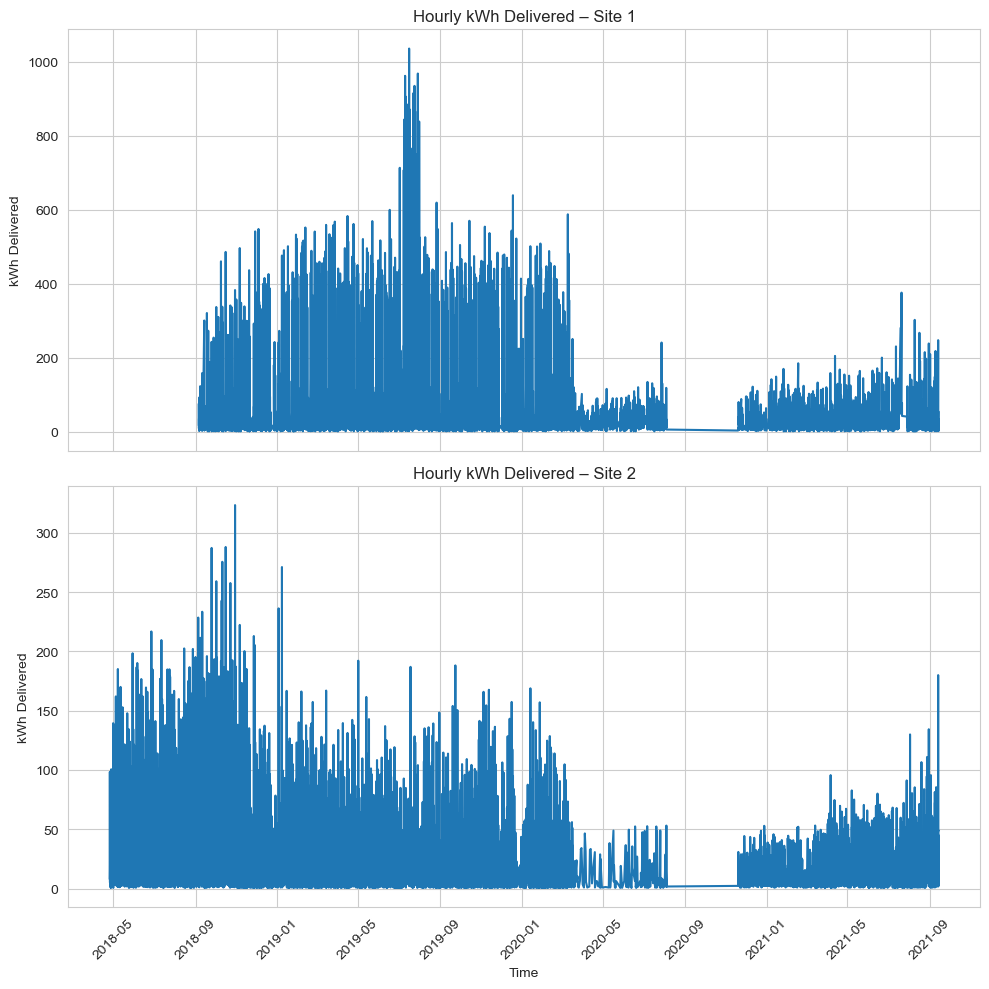

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns


charging_sessions['connectionTime'] = pd.to_datetime(charging_sessions['connectionTime'])
charging_sessions['hour'] = charging_sessions['connectionTime'].dt.floor('h')

hourly_kwh = (
    charging_sessions
    .groupby(['siteID', 'hour'], as_index=False)['kWhDelivered']
    .sum()
    .rename(columns={'kWhDelivered': 'kWh_hourly'})
)

site_ids = hourly_kwh['siteID'].unique()

fig, axes = plt.subplots(len(site_ids), 1, figsize=(10, 5 * len(site_ids)), sharex=True)

if len(site_ids) == 1:
    axes = [axes] 

for ax, site_id in zip(axes, site_ids):
    site_data = hourly_kwh.query('siteID == @site_id')
    sns.lineplot(data=site_data, x='hour', y='kWh_hourly', ax=ax)
    ax.set_title(f'Hourly kWh Delivered – Site {site_id}')
    ax.set_xlabel('Time')
    ax.set_ylabel('kWh Delivered')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
